In [53]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model


import numpy as np
import pandas as pd


print(tf.__version__)
print(keras.__version__)

2.16.2
3.6.0


# Load Data


In [45]:
rating = pd.read_csv("data/ratings.csv")
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [46]:
rating.describe() # movieId가 sequential 하지않아 시퀀스로 바꿈

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [47]:
movieId_to_seqId = {}
seqId_to_movieId = {}
for sId, id in enumerate(rating["movieId"].unique()):
    seqId_to_movieId[sId] = id
    movieId_to_seqId[id] = sId + 1
    
def return_movieId_to_seqId(row):
  return movieId_to_seqId[row.movieId]

rating["new_movieId"] = rating.apply(return_movieId_to_seqId, axis=1)

rating.describe() # 신규로 생성된 new_movieId 는 시퀀셜하게 되어있는것을 확인

,userId,movieId,rating,timestamp,new_movieId
count,100004.000000,100004.000000,100004.000000,1.000040e+05,100004.000000
mean,347.011310,12548.664363,3.543608,1.129639e+09,1661.778349
std,195.163838,26369.198969,1.058064,1.916858e+08,1893.955817
min,1.000000,1.000000,0.500000,7.896520e+08,1.000000
25%,182.000000,1028.000000,3.000000,9.658478e+08,328.000000
50%,367.000000,2406.500000,4.000000,1.110422e+09,874.000000
75%,520.000000,5418.000000,4.000000,1.296192e+09,2345.000000
max,671.000000,163949.000000,5.000000,1.476641e+09,9066.000000


In [48]:
rating.info() # 널값은 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       100004 non-null  int64  
 1   movieId      100004 non-null  int64  
 2   rating       100004 non-null  float64
 3   timestamp    100004 non-null  int64  
 4   new_movieId  100004 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.8 MB


In [54]:
from sklearn.model_selection import train_test_split

# get number of unique users and movies 
num_users = len(rating.userId.unique())
num_movies = len(rating.new_movieId.unique())

# Create rating embedding path 
rating_train_full, rating_test = train_test_split(rating, train_size= 0.8)
rating_train, rating_valid = train_test_split(rating_train_full, train_size= 0.8)

print(f"rating_train: {rating_train.shape}")
print(f"rating_test: {rating_test.shape}")
print(f"rating_valid: {rating_valid.shape}")

rating_train: (64002, 5)
rating_test: (20001, 5)
rating_valid: (16001, 5)


In [51]:
rating_train.head()

,userId,movieId,rating,timestamp,new_movieId
36845,265,1104,5.0,960056098,1955
84340,564,3089,3.0,974840798,989
52114,380,91077,3.5,1377901221,4858
94592,624,49220,2.5,1205610364,8085
75387,523,377,4.0,1202234758,65


### GMF Implementation


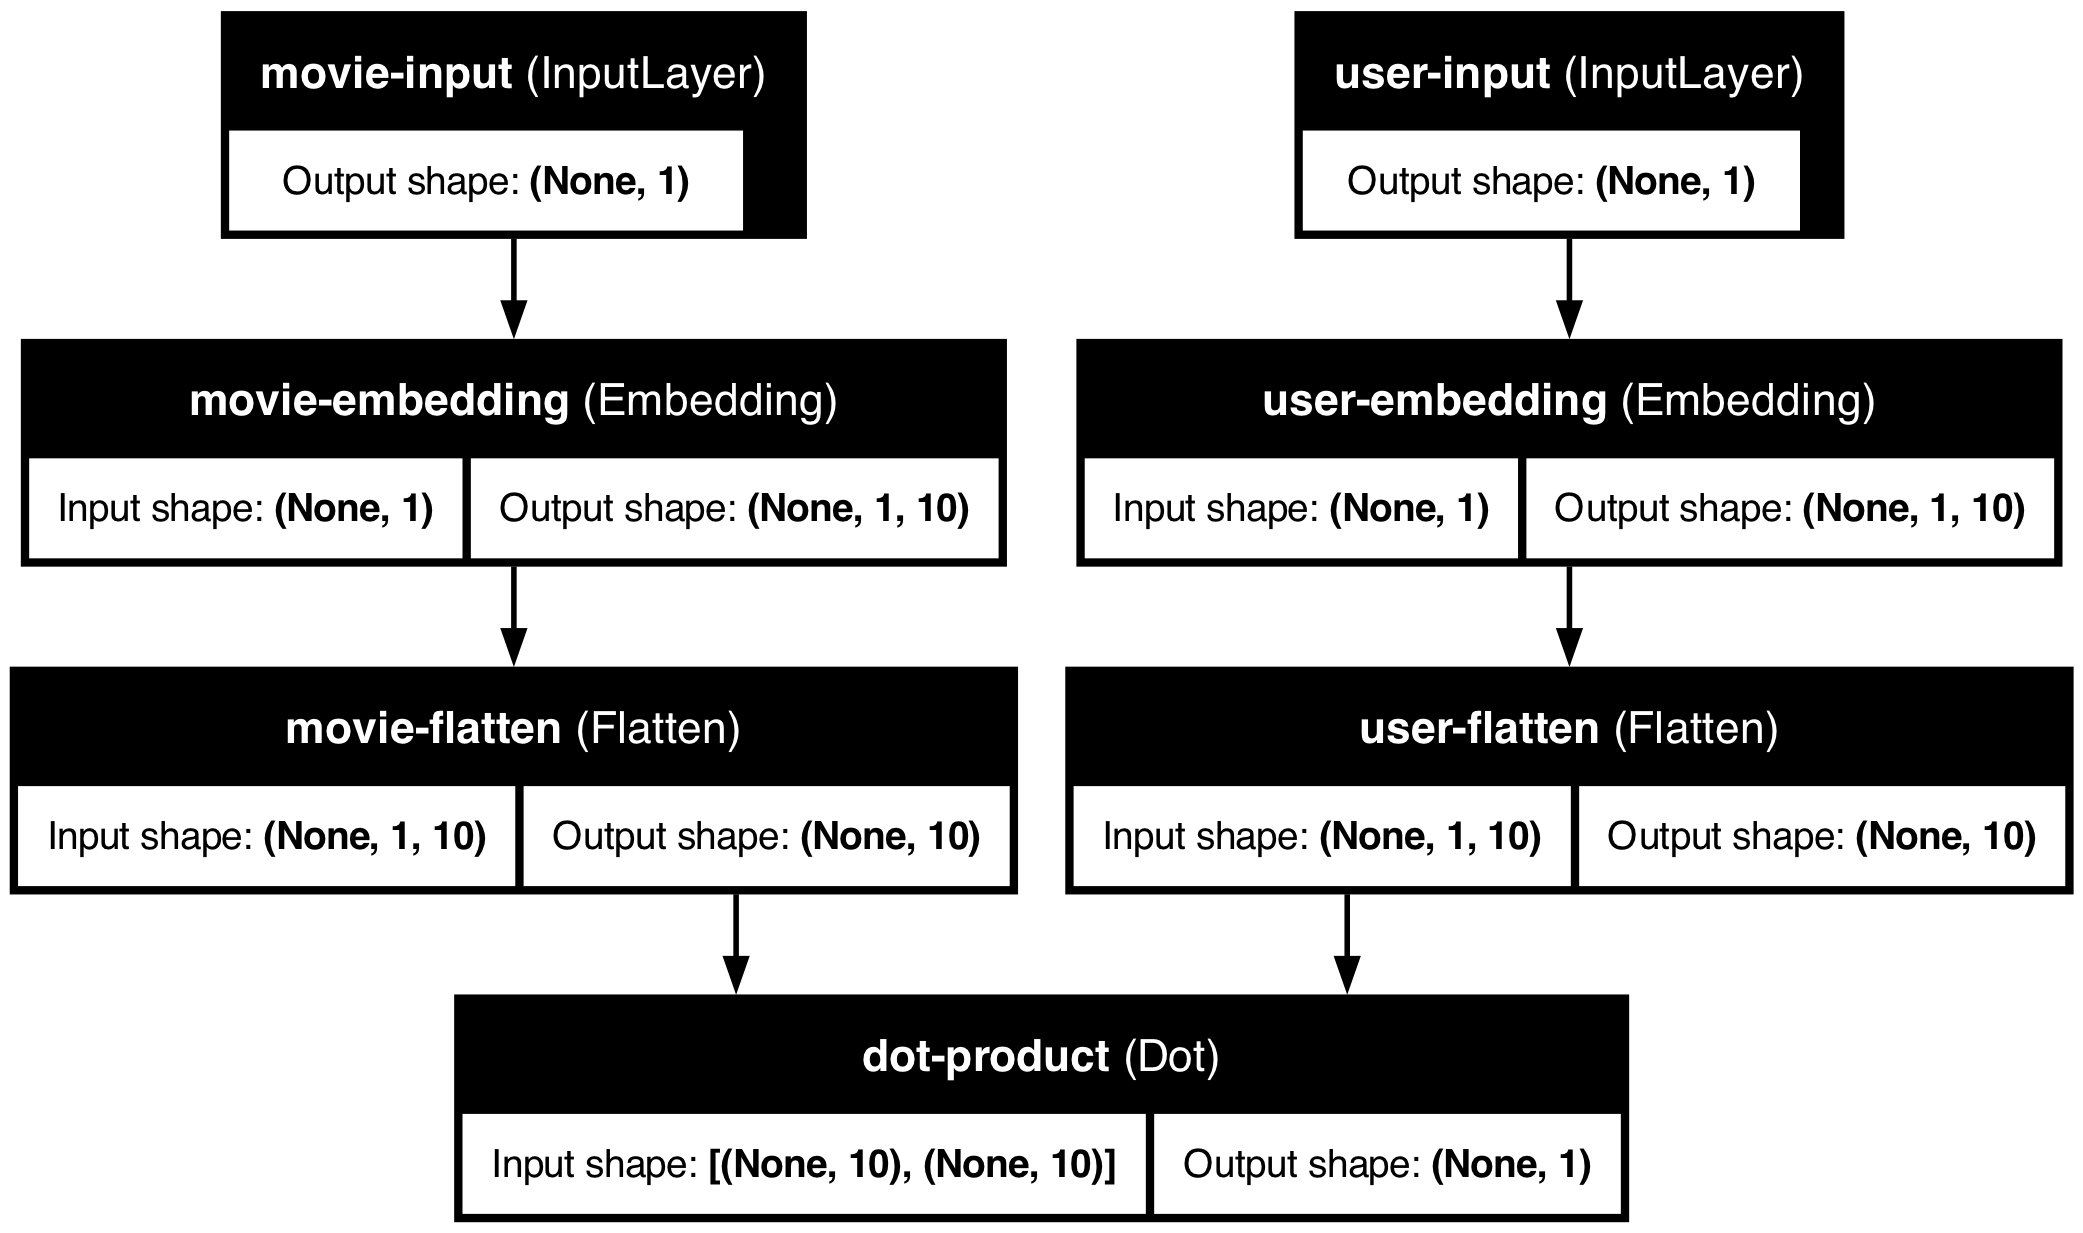

In [57]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate

# this could be optimized for item and user
latent_dim = 10


movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = Dot(axes=1, name='dot-product')([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [58]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie-input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding     │ (None, 1, 10)     │     90,670 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding      │ (None, 1, 10)     │      6,720 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-flatten       │ (None, 10)        │          0 │ movie-embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-flatten        │ (None, 10)        │          0 │ user-embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot-product (Dot)   │ (None, 1)         │          0 │ movie-flatten[0]… │
│                     │                   │            │ user-flatten[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,390 (380.43 KB)

 Trainable params: 97,390 (380.43 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# 텐서화 함수
def to_tensor(x):
    return tf.convert_to_tensor(x)

users_train = to_tensor(rating_train.userId.values)
users_valid = to_tensor(rating_valid.userId.values)
users_test = to_tensor(rating_test.userId.values)

items_train = to_tensor(rating_train.new_movieId.values)
items_valid = to_tensor(rating_valid.new_movieId.values)
items_test = to_tensor(rating_test.new_movieId.values)
